# Exercise 1: 

## a) ThePendulum

$
 \binom{\dot{\phi}}{\dot{\omega}} = \binom{\omega}{-b*\omega-\frac{g}{l}*\sin{\phi}}\\
 y(t) = \binom{\phi(t)}{\omega(t)}\\
 y(0) = \binom{initAngle}{initVelocity}
$

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
# Describe system of pendulum 
def pendulumModel (y, t, g, l, b):
    phi = y[0]
    omega = y[1]
    dphidt = omega
    domegadt = -b * omega - (g/l) * np.sin(phi)
    return [dphidt, domegadt]

#constants
g = 9.81
# length l of pendulum
l = 1

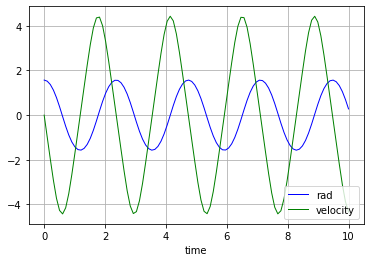

In [4]:
# Ideal pendlulum, friction 
# No friction
b = 0

# degree: 45, velocity: 0 
y0 = [np.pi/2, 0]
t = np.linspace(0,10, 100)
# Solve equation
res = odeint(pendulumModel,y0,t,args=(g, l, b))

# Plot results
plt.plot(t,res[:,0], 'b-', linewidth=1, label='rad')
plt.plot(t,res[:,1], 'g-', linewidth=1, label='velocity')
plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

In [5]:
# Pendulum with friction 
b1 = 0.25
b2 = 0.5
b3 = 0.75

# degree: 45, velocity: 0 
y0 = [np.pi/2, 0]
t = np.linspace(0,10, 150)

# Solve equation
res1 = odeint(pendulumModel,y0,t,args=(g, l, b1))
res2 = odeint(pendulumModel,y0,t,args=(g, l, b2))
res3 = odeint(pendulumModel,y0,t,args=(g, l, b3))



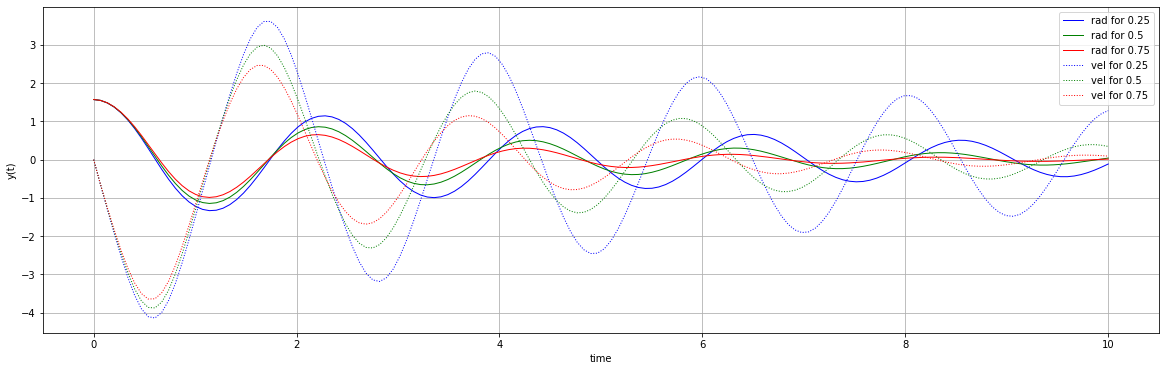

In [6]:
# Plot radiants
plt.plot(t,res1[:,0], 'b-', linewidth=1, label='rad for 0.25')
plt.plot(t,res2[:,0], 'g-', linewidth=1, label='rad for 0.5')
plt.plot(t,res3[:,0], 'r-', linewidth=1, label='rad for 0.75')
# Plot velocity
plt.plot(t,res1[:,1], ':b', linewidth=1, label='vel for 0.25')
plt.plot(t,res2[:,1], ':g', linewidth=1, label='vel for 0.5')
plt.plot(t,res3[:,1], ':r', linewidth=1, label='vel for 0.75')


plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()


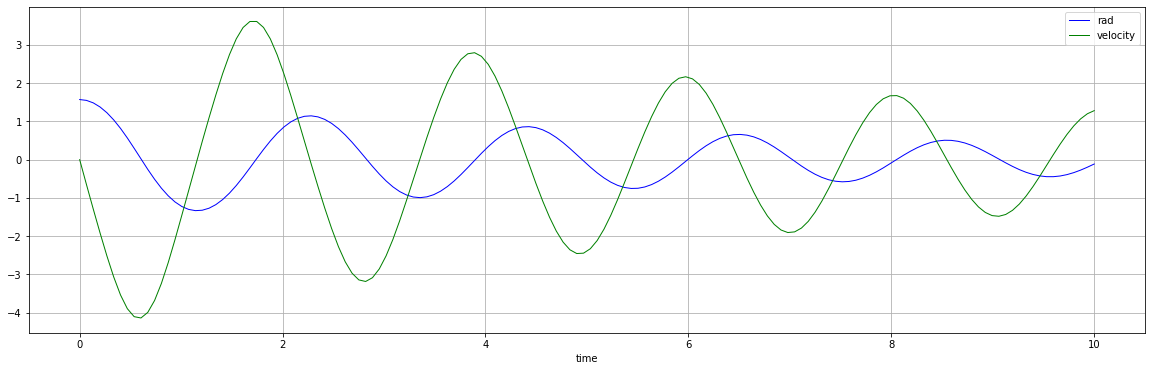

In [7]:
# Plot single results b1
plt.plot(t,res1[:,0], 'b-', linewidth=1, label='rad')
plt.plot(t,res1[:,1], 'g-', linewidth=1, label='velocity')
plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()


# Exercise 6
## (Dynamics of the COVID-19 infections - II)

A model targeted to the development in France is the Colizza INSERM study (Di Domenico et al,Expected impact of lockdown in Ile-de-France and possible exit strategies, Report #9, medRxiv.org). 

### a) Implement the Colizza model.


#### Analyse of the Colizza model

* Quelle 15 nicht in Paper enthalten
* Three age clases considered:
    1. 0-18 -> children (c)
    2. 19-64 -> adults (a)
    3. 65+ -> seniors (s)
* Social contact mactrices from 2012 (link 16)
    * represents mixing of individuals without interventions
    * Also split in multiple contact spots (household, school, workplace, transport, leisure, other)
    * Intervention measures are modeled as modifications of contact matrices
   
* Created with SEIR Model (kind of) Abbildung 2 (Wikipedia)
* Reduzierung der I states auf 1 im ersten schritt, keine Unterscheidung zwischen symptomatic, etc

#### Modell erstellen

Ziel ist das erstellen einer Kontaktmatrix basierend auf einem contact spot. 
Hieraus soll anschließend mit gegebenen Parametern (ansteckungsrate, ???) errechnet werden, wie viele Personen infiziert sind

Einschränkung:
* Im ersten Schritt nur einen Zustand für kranke
* Ausklammern von eigenisolation


#### Zielsetzung

* Für das Fallbeispiel Haushalt (feste übertragungsrate pro Altersgruppe) Modellierung umsetzen
* Vereinfachte Form der Krankheitszustände anwenden
* Wenn möglich eine Einschränkung auf das Fallbeispiel anwenden
* Mögliche Ergebnisse diskutieren

#### Design of the model

The goal is to design a Colliza like model. 
The developing is devided into three parts:
1. Contact matrix
2. Coding the compartimental model
3. Filling the model with parameters

Using the output of the model, we can describe the development of the pandemi.
This is our baseline used to verify applyed countermeasures.

#### Creating the contact matrix 

The main contact matrix is based on multiple contact matrices where every matrix stands for a given situation and it's unique contacts per person.

By adding every element onto each other, we get the total amount of contacts per person.
Because we devided the daily live into 6 parts, we also have to devide the resulting matrix by 6 to get our matrix k. 
This matrix represents all situation and can be used in the model.

The created matrix will fit as a baseline and helps to verify countermeasures.

In [229]:
# Kontaktmatrix muss aus verschiedenen situationen/Räumen zusammengerechnet werden
# Wenn Zeit ist ist das ein weiteres Thema, 
# eigentlich essentiell da dadurch überhaupt die Kontaktsperren gemessen werden können (zumindest genauer)

# Weitere mögliche Anpassung: Gewichtung der Räume, wie viel Zeit verbringt man da? -> SUM=1
p_household = 1/6
p_school = 1/6
p_workplace = 1/6
p_transport = 1/6
p_leisure = 1/6
p_other = 1/6

# Orte: household, school, workplace, transport, leisure, other

# Pro Ort eine Kontaktmatrix
k_household = [
    [8, 5, 4], # c -> c,a,s
    [1.2, 7, 2], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_school = [
    [8, 5, 4], # c -> c,a,s
    [1.2, 7, 2], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_workplace = [
    [8, 5, 4], # c -> c,a,s
    [1.2, 7, 2], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_transport = [
    [8, 5, 4], # c -> c,a,s
    [1.2, 7, 2], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_leisure = [
    [8, 5, 4], # c -> c,a,s
    [1.2, 7, 2], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_other = [
    [8, 5, 4], # c -> c,a,s
    [1.2, 7, 2], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

# Resulting contact matrix
# Kontaktmatrix (3x3):
k = [[1, 1, 1], # c -> c,a,s
     [1, 1, 1], # a -> c,a,s
     [1, 1, 1]] # s -> c,a,s

for i in range(3):
    for j in range(3):
        k[i][j] = k_household[i][j] * p_household + k_school[i][j] * p_school + k_workplace[i][j] * p_workplace + k_transport[i][j] * p_transport + k_leisure[i][j] * p_leisure + k_other[i][j] * p_other
        #k[i][j] = k[i][j]/6 # could be replaced by p values       

##### Compartimental model

---- Graphisches model einfügen -----

Description of differential equation used

As we can see in the diagram, the model uses a bunch of parameters to calculate the resulting curve.  
We have used parameters to describe the infection rate (b), the contacts between our subgroups of the population (k, compare *Link*), the individual chances for the different progressions of the illnes (e, p_a, p_ps, p_ms, p_ss, u_p) and the healing rate (u, l_icud, l_hd).  
To describe the critical progressions, we have parameters to model how many people are in the icu and how many people die in the hospital (p_icu, l_hr, l_icur).

The whole system could be described in a simple way via the system of first order ordinarydifferential equations:

$$
 \begin{pmatrix}
     \frac{dS}{dt}\\
     \frac{dE}{dt}\\
     \frac{dI_{p}}{dt}\\
     \frac{dI_{a}}{dt}\\
     \frac{dI_{ps}}{dt}\\
     \frac{dI_{ms}}{dt}\\
     \frac{dI_{ss}}{dt}\\
     \frac{dH}{dt}\\
     \frac{dI_{ICU}}{dt}\\
     \frac{dR}{dt}\\
     \frac{dD}{dt}
 \end{pmatrix}
 = 
 \begin{pmatrix}
     -b * S *(I_{p} + I_{a} + I_{ps} + I_{ms} + I_{ss})\\
     b * S * (I_{p} + I_{a} + I_{ps} + I_{ms} + I_{ss}) -e * E\\
     e*E - u_{p} * I_{p}\\
     p_{a}*u_{p}*I_{p} - u * I_{a}\\
     (1-p_{a}) * p_{ps} * u_{p} * I_{p} - u * I_{ps}\\
     (1-p_{a})* p_{ms} * u_{p} * I_{p} - u * I_{ms}\\
     (1-p_{a})* p_{ss} * u_{p} * I_{p} - u * I_{ss}\\
     (1 - p_{ICU}) * u * I_{ss} - (\lambda_{H,R} + \lambda_{H,D}) * H\\
     p_{ICU} * u * I_{ss} - (\lambda_{ICU,R} + \lambda_{ICU,D}) * ICU\\
     u * (I_{a} + I_{ps} + I_{ms}) + l_{H,R} * H + l_{ICU,R} * ICU \\
     l_{H,D} * H + l_{ICU,D} * ICU
 \end{pmatrix}
$$ 

One important part of the model is the separation of the population in three parts (c, a, s). 
We have different chances in the different groups for the infection rate and the progression.  
To represent this, we have for every group a separated model.
The only contact between these three models is the infection phase.
Children can not only infect other children, but also adults and seniors.

By calculating one curve, we calculate infact three developments affecting each other.  
The resulting model is defined in function *casModel1(...)*.


In [223]:
def casModel1(status, t, b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud):
    # nach I_p, teilt sich auf in p_a, p_ps, p_ms, p_ss und u_p, u
    #S, E, I_p, I_a, I_ps, I_ms, I_ss,H, ICU, R, D = status
    S = np.empty(3, dtype=float)
    E = np.empty(3, dtype=float)
    I_p = np.empty(3, dtype=float)
    I_a = np.empty(3, dtype=float)
    I_ps = np.empty(3, dtype=float)
    I_ms = np.empty(3, dtype=float)
    I_ss = np.empty(3, dtype=float)
    H = np.empty(3, dtype=float)
    ICU = np.empty(3, dtype=float)
    R = np.empty(3, dtype=float)
    D = np.empty(3, dtype=float)
    
    for i in range(3):
        S[i] = status[0 + i]
        E[i] = status[3 + i]
        I_p[i] = status[6 + i]
        I_a[i] = status[9 + i]
        I_ps[i] = status[12 + i]
        I_ms[i] = status[15 + i]
        I_ss[i] = status[18 + i]
        H[i] = status[21 + i]
        ICU[i] = status[24 + i]
        R[i] = status[27 + i]
        D[i] =status[ 30 + i]
    
    #prepare return arrays
    dSdT = np.empty(3, dtype=float)
    dEdT = np.empty(3, dtype=float)
    dI_pdT = np.empty(3, dtype=float)
    dI_adT = np.empty(3, dtype=float)
    dI_psdT = np.empty(3, dtype=float)
    dI_msdT = np.empty(3, dtype=float)
    dI_ssdT = np.empty(3, dtype=float)
    dHdT = np.empty(3, dtype=float)
    dICUdT = np.empty(3, dtype=float)
    dRdT = np.empty(3, dtype=float)
    dDdT = np.empty(3, dtype=float)
    
    for i in range(3):     
        dSdT[i] = -b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] ))
        dEdT[i] = b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] )) - e[i] * E[i]
        
        dI_pdT[i] = e[i] * E[i] - u_p[i]* (p_a[i]  + (1 - p_a[i]) * (p_ps[i] + p_ms[i] + p_ss[i])) * I_p[i] 
        dI_adT[i] = p_a[i] * u_p[i] * I_p[i] - u[i] * I_a[i]
        dI_psdT[i] = (1 - p_a[i]) * p_ps[i] * u_p[i] * I_p[i] - u[i] * I_ps[i]
        dI_msdT[i] = (1 - p_a[i]) * p_ms[i] * u_p[i] * I_p[i] - u[i] * I_ms[i]
        dI_ssdT[i] = (1 - p_a[i]) * p_ss[i] * u_p[i] * I_p[i] - u[i] * I_ss[i]    
        dHdT[i] = (1 - p_icu[i]) * u[i] * I_ss[i] - (l_hr[i] + l_hd[i]) * H[i]
        dICUdT[i] = p_icu[i] * u[i] * I_ss[i] - (l_icur[i] + l_icud[i]) * ICU[i]   
        dRdT[i] = u[i] * (I_a[i] + I_ps[i] + I_ms[i]) + l_hr[i] * H[i] + l_icur[i] * ICU[i] 
        dDdT[i] = l_hd[i] * H[i] + l_icud[i] * ICU[i]
    
    return [dSdT[0], dSdT[1], dSdT[2], dEdT[0], dEdT[1], dEdT[2], dI_pdT[0], dI_pdT[1], dI_pdT[2], dI_adT[0], dI_adT[1], dI_adT[2], dI_psdT[0], dI_psdT[1], dI_psdT[2], dI_msdT[0], dI_msdT[1], dI_msdT[2], dI_ssdT[0], dI_ssdT[1], dI_ssdT[2], dHdT[0], dHdT[1], dHdT[2], dICUdT[0], dICUdT[1], dICUdT[2], dRdT[0], dRdT[1], dRdT[2], dDdT[0], dDdT[1], dDdT[2] ]

#### Creating a baseline

the follwing cell defines the baseline of our model.  
The values are extracted from the paper).
Some of the used values were not described. 
Therefor a guess was made for the baseline.

In [230]:
# status vector: [S, I, D, R]
# population ile de france in %: c:26%, a:59%, s:15%, 12.21mio total
total = 12210000
ill = 500
status0=[total*0.26, total*0.29, total*0.15, ill*0.26, ill*0.29, ill*0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0,120, 150)

# Incubation period = 5.2 d
# duration prodromal phase = 1.5d
# latency period = 1/(5.2-1.5)

#p_a, p_ps, p_ms, p_ss und u_p, u
# Use tuple for static params
e = (1/3.7, 1/3.7, 1/3.7)
p_a = (0.5, 0.2, 0.1)
p_ps = (1, 0.2, 0.2)
p_ms = (0, 0.7, 0.6)
p_ss = (0, 0.1, 0.2) 
u_p = (1/1.5, 1/1.5, 1/1.5)
u = (1/2.3, 1/2.3, 1/2.3) # u^-1=2.3
p_icu = (0, 0.36, 0.2)
l_hr = (0, 0.36, 0.2)
l_hd = (0, 0.072 , 0.022)
l_icur = (0, 0.05, 0.036)
l_icud = (0, 0.0074, 0.029)

# Calculate infection rate
# relative infectivenes (0.51) vs reduced for ss, they reduce contact by 75%
attackRate = (0.1, 0.01, 0.01)
b = (attackRate[0]/status0[0], attackRate[1]/status0[1], attackRate[2]/status0[2])
# Big questionmark, controls mainly the curve


# Einzelne gewichtungen der kontakte abhängig von I
# I_a, I_ps, I_ms, I_ss -> All 1 = no self isolation
# Self isolation of people with sever symptoms (reduces contact by 75%)
# Isolation of groups -> Ia, Ips, Ims, Iss
k_i = [1, 1, 1, 0.25]

# solve equation
res = odeint(casModel1,status0,t,args=(b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud))

#### Aufbereitung

Anzeige der Daten, aufbereitung (r0 entwicklung) sowie print einzelner Kennzahlen

1. death and recovered
2. Infected people development
3. Hospital and ICU 
5. Whole Data by age class

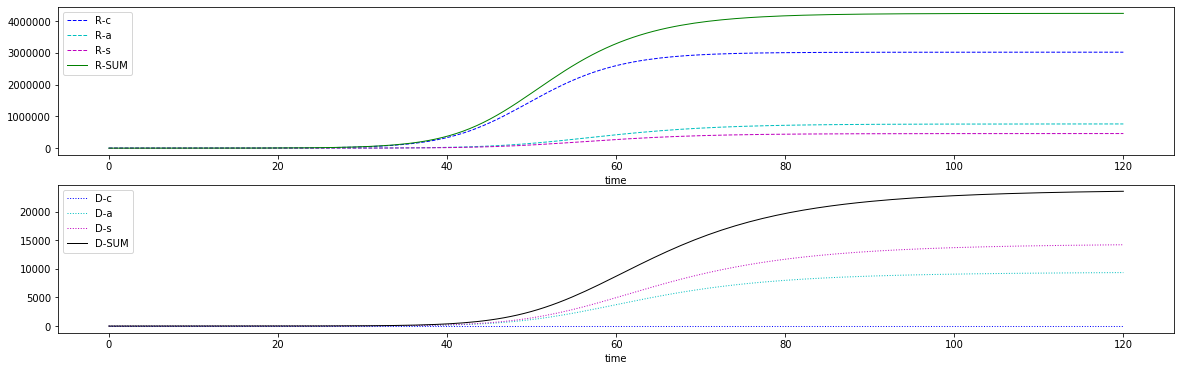

In [231]:
# 1. death and recovered
plt.title('death and recovered')

# recovered
plt.subplot(2, 1, 1)
# Children
plt.plot(t,res[:,27], 'b--', linewidth=1, label='R-c')
# Adults
plt.plot(t,res[:,28], 'c--', linewidth=1, label='R-a')
# Seniors
plt.plot(t,res[:,29], 'm--', linewidth=1, label='R-s')
# Total
plt.plot(t,res[:,27] + res[:,28] + res[:,29], 'g-', linewidth=1, label='R-SUM')
plt.xlabel('time')
plt.legend(loc='best')

# death
plt.subplot(2, 1, 2)
# Children
plt.plot(t,res[:,30], 'b:', linewidth=1, label='D-c')
# Adults
plt.plot(t,res[:,31], 'c:', linewidth=1, label='D-a')
# Seniors
plt.plot(t,res[:,32], 'm:', linewidth=1, label='D-s')
# Total
plt.plot(t,res[:,30] + res[:,31] + res[:,32], 'k-', linewidth=1, label='D-SUM')
plt.xlabel('time')
plt.legend(loc='best')


plt.rcParams['figure.figsize'] = (20,12)
plt.show()



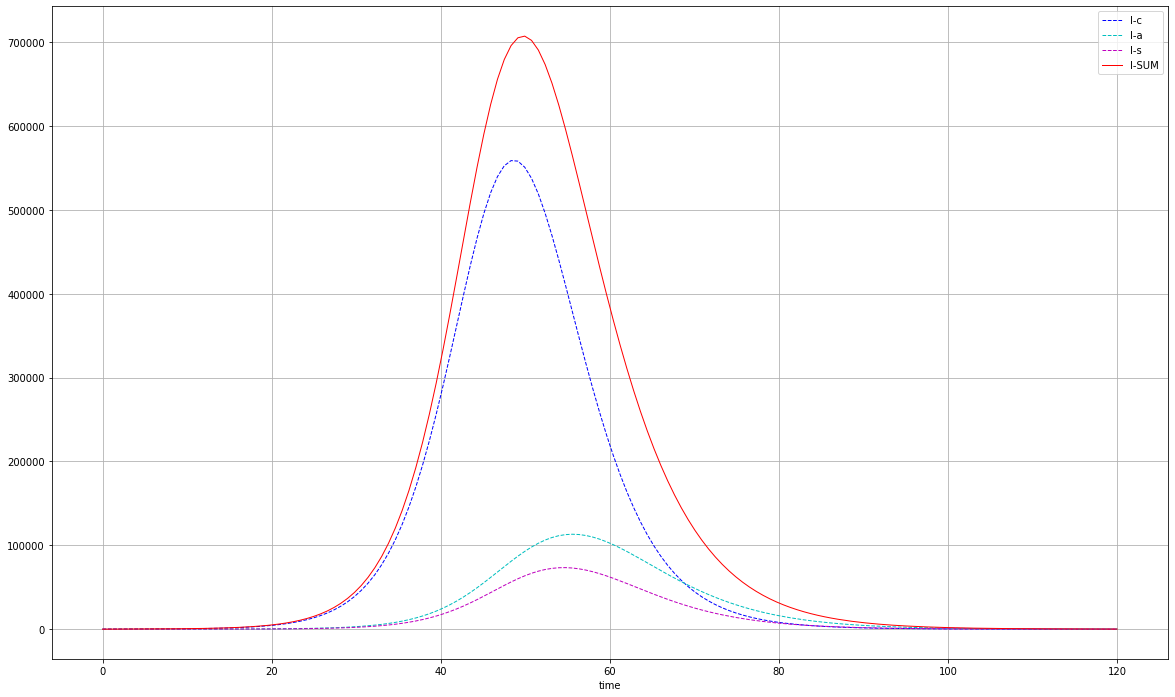

In [232]:
# 2. Total Infected people

# Children
plt.plot(t,res[:,6] + res[:,9] + res[:,12] + res[:,15] + res[:,18], 'b--', linewidth=1, label='I-c')
# Adults
plt.plot(t,res[:,7] + res[:,10] + res[:,13] + res[:,16] + res[:,19], 'c--', linewidth=1, label='I-a')
# Seniors
plt.plot(t,res[:,8] + res[:,11] + res[:,14] + res[:,17] + res[:,20], 'm--', linewidth=1, label='I-s')
# Total
plt.plot(t,res[:,6] + res[:,9] + res[:,12] + res[:,15] + res[:,18] + res[:,7] + res[:,10] + res[:,13] + res[:,16] + res[:,19] + res[:,8] + res[:,11] + res[:,14] + res[:,17] + res[:,20], 'r-', linewidth=1, label='I-SUM')

plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

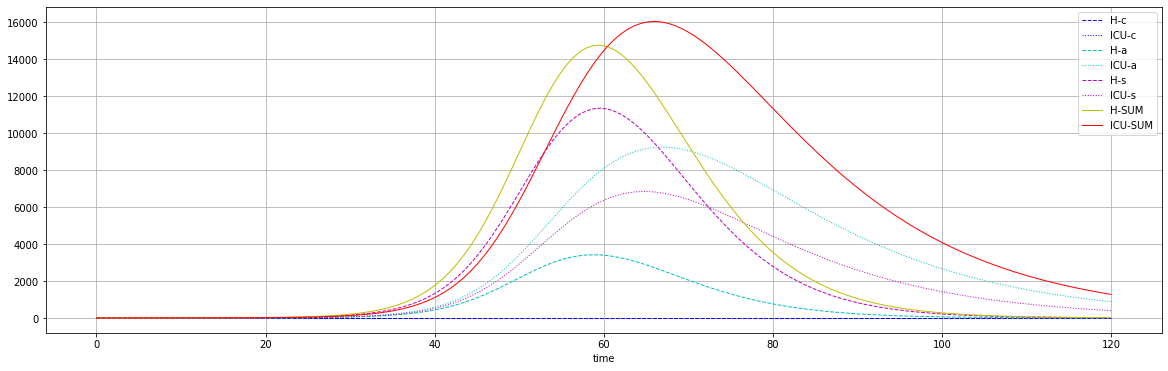

In [233]:
# 3. Hospital and ICU

# Children
plt.plot(t,res[:,21], 'b--', linewidth=1, label='H-c')
plt.plot(t,res[:,24], 'b:', linewidth=1, label='ICU-c')
# Adults
plt.plot(t,res[:,22], 'c--', linewidth=1, label='H-a')
plt.plot(t,res[:,25], 'c:', linewidth=1, label='ICU-a')
# Seniors
plt.plot(t,res[:,23], 'm--', linewidth=1, label='H-s')
plt.plot(t,res[:,26], 'm:', linewidth=1, label='ICU-s')
# Total
plt.plot(t,res[:,21] + res[:,22] + res[:,23], 'y-', linewidth=1, label='H-SUM')
plt.plot(t,res[:,24] + res[:,25] + res[:,26], 'r-', linewidth=1, label='ICU-SUM')

plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

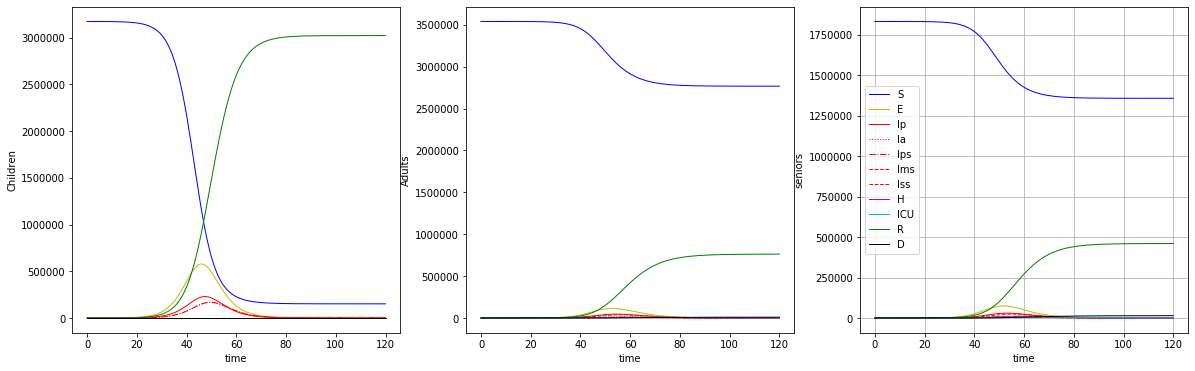

In [234]:
# Whole data by group
plt.title('Covid19 pandemic simulation')
# Children
step = 0
plt.subplot(1, 3, 1)
plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')
plt.xlabel('time')
plt.ylabel('Children')

# Adults
step = 1
plt.subplot(1, 3, 2)
plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')
plt.xlabel('time')
plt.ylabel('Adults')

# Seniors
step = 2
plt.subplot(1, 3, 3)
plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')
plt.xlabel('time')
plt.ylabel('seniors')


plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

#### Modify the parameters for one type of countermeasures

In the following we create a second configuration, based on the effects of a given counter measure (welche?). 
The effects of this measure on the behaviour is extracted from the paper. 
As described earlyer, the paper focus on ile de france.

After running the model with new inputs, we can see, what effect the method had compared to to our baseline.

In [213]:
# Kontaktmatrix muss aus verschiedenen situationen/Räumen zusammengerechnet werden
# Wenn Zeit ist ist das ein weiteres Thema, 
# eigentlich essentiell da dadurch überhaupt die Kontaktsperren gemessen werden können (zumindest genauer)

# Weitere mögliche Anpassung: Gewichtung der Räume, wie viel Zeit verbringt man da? -> SUM=1
p_household = 1/6
p_school = 1/6
p_workplace = 1/6
p_transport = 1/6
p_leisure = 1/6
p_other = 1/6

# Orte: household, school, workplace, transport, leisure, other

# Pro Ort eine Kontaktmatrix
k_household = [
    [8, 5, 0.7], # c -> c,a,s
    [1.2, 7, 1.5], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_school = [
    [8, 5, 1], # c -> c,a,s
    [1.2, 7, 1.6], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_workplace = [
    [8, 5, 1], # c -> c,a,s
    [1.2, 7, 1.6], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_transport = [
    [8, 5, 1], # c -> c,a,s
    [1.2, 7, 1.6], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_leisure = [
    [8, 5, 1], # c -> c,a,s
    [1.2, 7, 1.6], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

k_other = [
    [8, 5, 1], # c -> c,a,s
    [1.2, 7, 1.6], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s

# Resulting contact matrix
# Kontaktmatrix (3x3):
k = [[1, 1, 1], # c -> c,a,s
     [1, 1, 1], # a -> c,a,s
     [1, 1, 1]] # s -> c,a,s

for i in range(3):
    for j in range(3):
        k[i][j] = k_household[i][j] * p_household + k_school[i][j] * p_school + k_workplace[i][j] * p_workplace + k_transport[i][j] * p_transport + k_leisure[i][j] * p_leisure + k_other[i][j] * p_other
        #k[i][j] = k[i][j]/6 # could be replaced by p values       

In [224]:
# status vector: [S, I, D, R]
# population ile de france in %: c:26%, a:59%, s:15%, 12.21mio total
total = 12210000
ill = 500
status0=[total*0.26, total*0.29, total*0.15, ill*0.26, ill*0.29, ill*0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0,120, 150)

# Incubation period = 5.2 d
# duration prodromal phase = 1.5d
# latency period = 1/(5.2-1.5)

#p_a, p_ps, p_ms, p_ss und u_p, u
# Use tuple for static params
e = (1/3.7, 1/3.7, 1/3.7)
p_a = (0.5, 0.2, 0.1)
p_ps = (1, 0.2, 0.2)
p_ms = (0, 0.7, 0.6)
p_ss = (0, 0.1, 0.2) 
u_p = (1/1.5, 1/1.5, 1/1.5)
u = (1/2.3, 1/2.3, 1/2.3) # u^-1=2.3
p_icu = (0, 0.36, 0.2)
l_hr = (0, 0.36, 0.2)
l_hd = (0, 0.072 , 0.022)
l_icur = (0, 0.05, 0.036)
l_icud = (0, 0.0074, 0.029)

# Calculate infection rate
# relative infectivenes (0.51) vs reduced for ss, they reduce contact by 75%
attackRate = (0.1, 0.01, 0.01)
b = (attackRate[0]/status0[0], attackRate[1]/status0[1], attackRate[2]/status0[2])
# Big questionmark, controls mainly the curve


# Einzelne gewichtungen der kontakte abhängig von I
# I_a, I_ps, I_ms, I_ss -> All 1 = no self isolation
# Self isolation of people with sever symptoms (reduces contact by 75%)
# Isolation of groups -> Ia, Ips, Ims, Iss
k_i = [1, 1, 1, 0.25]

# solve equation
res = odeint(casModel1,status0,t,args=(b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud))

#### Aufbereitung

Anzeige der Daten, aufbereitung (r0 entwicklung) sowie print einzelner Kennzahlen

1. death and recovered
2. Infected people development
3. Hospital and ICU 
5. Whole Data by age class

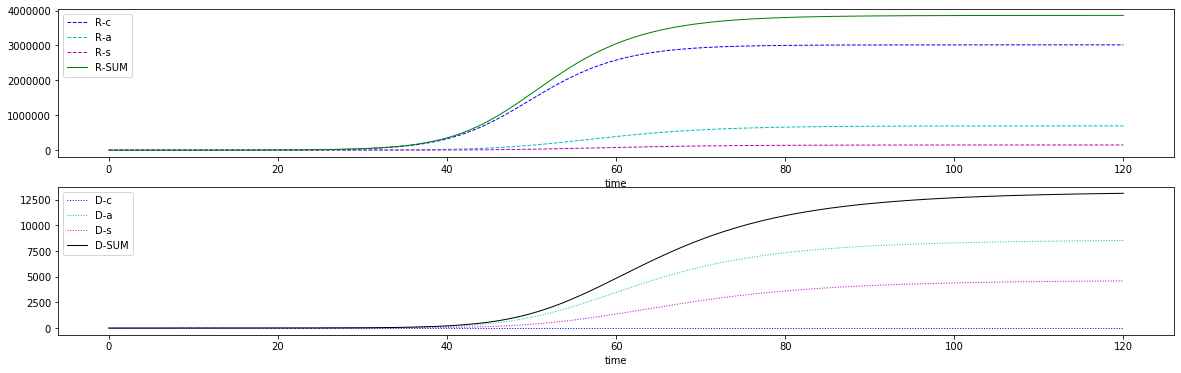

In [225]:
# 1. death and recovered
plt.title('death and recovered')

# recovered
plt.subplot(2, 1, 1)
# Children
plt.plot(t,res[:,27], 'b--', linewidth=1, label='R-c')
# Adults
plt.plot(t,res[:,28], 'c--', linewidth=1, label='R-a')
# Seniors
plt.plot(t,res[:,29], 'm--', linewidth=1, label='R-s')
# Total
plt.plot(t,res[:,27] + res[:,28] + res[:,29], 'g-', linewidth=1, label='R-SUM')
plt.xlabel('time')
plt.legend(loc='best')

# death
plt.subplot(2, 1, 2)
# Children
plt.plot(t,res[:,30], 'b:', linewidth=1, label='D-c')
# Adults
plt.plot(t,res[:,31], 'c:', linewidth=1, label='D-a')
# Seniors
plt.plot(t,res[:,32], 'm:', linewidth=1, label='D-s')
# Total
plt.plot(t,res[:,30] + res[:,31] + res[:,32], 'k-', linewidth=1, label='D-SUM')
plt.xlabel('time')
plt.legend(loc='best')


plt.rcParams['figure.figsize'] = (20,12)
plt.show()



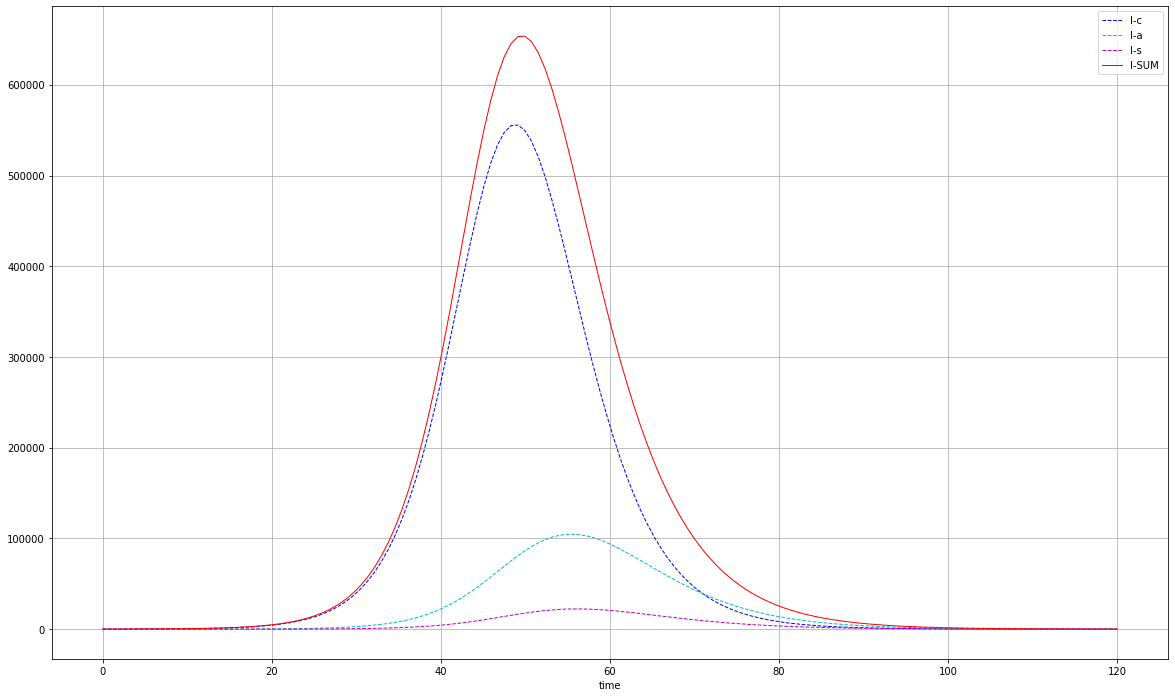

In [226]:
# 2. Total Infected people

# Children
plt.plot(t,res[:,6] + res[:,9] + res[:,12] + res[:,15] + res[:,18], 'b--', linewidth=1, label='I-c')
# Adults
plt.plot(t,res[:,7] + res[:,10] + res[:,13] + res[:,16] + res[:,19], 'c--', linewidth=1, label='I-a')
# Seniors
plt.plot(t,res[:,8] + res[:,11] + res[:,14] + res[:,17] + res[:,20], 'm--', linewidth=1, label='I-s')
# Total
plt.plot(t,res[:,6] + res[:,9] + res[:,12] + res[:,15] + res[:,18] + res[:,7] + res[:,10] + res[:,13] + res[:,16] + res[:,19] + res[:,8] + res[:,11] + res[:,14] + res[:,17] + res[:,20], 'r-', linewidth=1, label='I-SUM')

plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

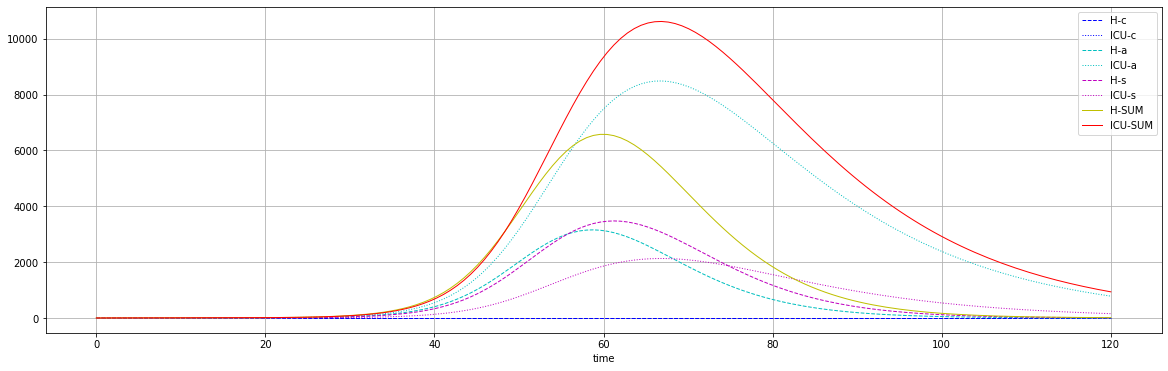

In [227]:
# 3. Hospital and ICU

# Children
plt.plot(t,res[:,21], 'b--', linewidth=1, label='H-c')
plt.plot(t,res[:,24], 'b:', linewidth=1, label='ICU-c')
# Adults
plt.plot(t,res[:,22], 'c--', linewidth=1, label='H-a')
plt.plot(t,res[:,25], 'c:', linewidth=1, label='ICU-a')
# Seniors
plt.plot(t,res[:,23], 'm--', linewidth=1, label='H-s')
plt.plot(t,res[:,26], 'm:', linewidth=1, label='ICU-s')
# Total
plt.plot(t,res[:,21] + res[:,22] + res[:,23], 'y-', linewidth=1, label='H-SUM')
plt.plot(t,res[:,24] + res[:,25] + res[:,26], 'r-', linewidth=1, label='ICU-SUM')

plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

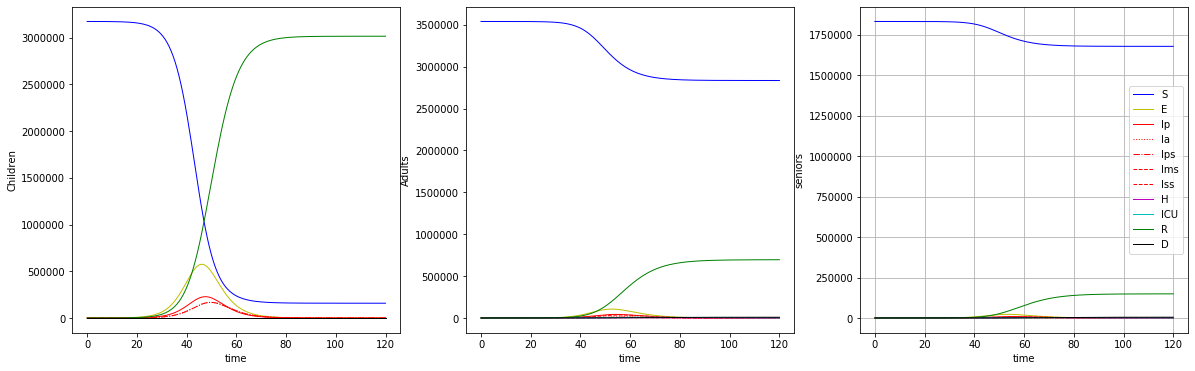

In [228]:
# Whole data by group
plt.title('Covid19 pandemic simulation')
# Children
step = 0
plt.subplot(1, 3, 1)
plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')
plt.xlabel('time')
plt.ylabel('Children')

# Adults
step = 1
plt.subplot(1, 3, 2)
plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')
plt.xlabel('time')
plt.ylabel('Adults')

# Seniors
step = 2
plt.subplot(1, 3, 3)
plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')
plt.xlabel('time')
plt.ylabel('seniors')


plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

### b) Conclusion about Colliza model

Großes Fragezeichen: Konfidenzintervalle????
-> Im text, confidenzintervall 95%

The model implemented works like the Colliza model from the paper (link). 
It is obvious that there are differents between the implemented model and the original one. 
One of the main reasons for this is the lack of implementation details of the working group. 
Still the implementation helped to get a clearer view about the model. 

Even at a first glance, we can see the huge amount of configuration possibilities. 
In the model above, we have around 100 parameters controlled by the user. 
This complexity gives us the chance to really get a feeling, what counter measures against Covid19 could have a bigger impact than others.

The implementation shows that we have a powerful model specialized on behaviour of the people together with the different stages of the illnes and our daily life. 


The biggest advantage of the model, the complexity and all configuration options, is also its biggest disadvantage. 
To get accurate information out of this model, we need lots of different data inputs. 
Without other academic studies on the pandemy giving all the information we need, we cannot give a good guess on how things are going. 

One big danger of this model is a wrong understanding on the accuracy of it. 
The underlying paper tryes to give a baseline for politicians to decide what counter measures are useful and should be applied. 
Because we realy on many data sources we could have a fatal feeling of security while applying the actions (or removing measures).


The paper also discussed different exit strategies and their effects. 
One major point is the capacity of the health care system. 
The paper gives an advice about what measures could lead into a health-care-friendly development of the pandemi. 

Because of the huge amount of simulations done in this paper, we were not able to verify this data with our model. 
Stil, with more time, it would be possible to get our own numbers out of the model.

### c) Compare the Colliza model with other implemented Models

# Testing area

All following examples are created for testing and will not be included in the final document

In [15]:
initPeople = sum(i for i in status0)
print(initPeople)

3000065


In [8]:
def simpleModel2(status, t, b, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud):
    # nach I_p, teilt sich auf in p_a, p_ps, p_ms, p_ss und u_p, u
    S, E, I_p, I_a, I_ps, I_ms, I_ss,H, ICU, R, D = status

    dSdT = -b * S *(I_p + I_a + I_ps + I_ms + I_ss)
    dEdT = b * S * (I_p + I_a + I_ps + I_ms + I_ss) -e * E
    dI_pdT = e*E - u_p * I_p
    dI_adT = p_a*u_p*I_p - u * I_a
    dI_psdT = (1-p_a) * p_ps * u_p * I_p - u * I_ps
    dI_msdT = (1-p_a)* p_ms * u_p * I_p - u * I_ms
    dI_ssdT = (1-p_a)* p_ss * u_p * I_p - u * I_ss
    
    dHdT = (1 - p_icu) * u * I_ss - (l_hr + l_hd) * H
    dICUdT = p_icu * u * I_ss - (l_icur + l_icud) * ICU
    
    dRdT = u * (I_a + I_ps + I_ms) + l_hr * H + l_icur * ICU 
    dDdT = l_hd * H + l_icud * ICU
    
    return [dSdT, dEdT, dI_pdT, dI_adT, dI_psdT, dI_msdT, dI_ssdT, dHdT, dICUdT, dRdT, dDdT ]

In [9]:
# status vector: [S, I, D, R]
status0=[1000000, 20, 15, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0,720, 800)
#p_a, p_ps, p_ms, p_ss und u_p, u
b = 0.00000007
e = 0.03
p_a = 0.1
p_ps = 0.01
p_ms = 0.01
p_ss = 0.20
u_p = 0.01
u = 0.1
p_icu = 0.01
l_hr = 0.002
l_hd = 0.001 
l_icur = 0.001
l_icud = 0.007

res = odeint(simpleModel2,status0,t,args=(b, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud))
# Plot 
print(res.shape)

(800, 11)


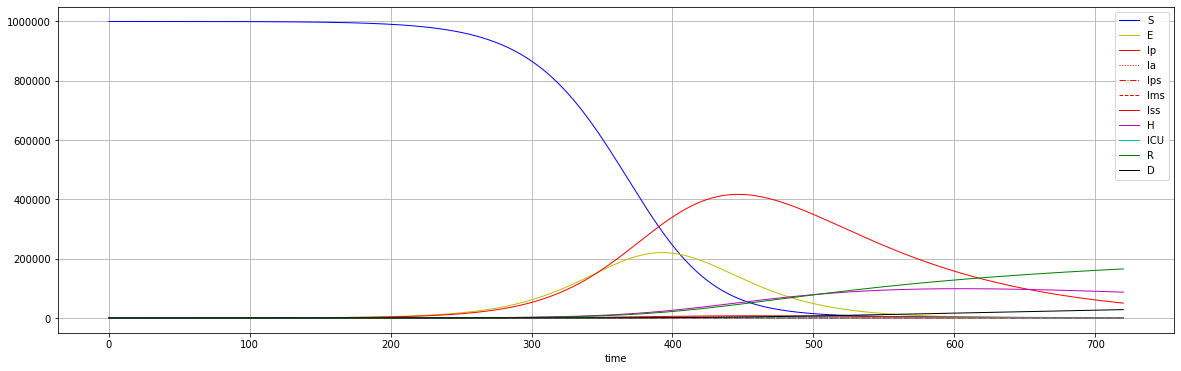

In [10]:
plt.plot(t,res[:,0], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,1], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,2], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,3], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,4], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,5], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,6], 'r-', linewidth=1, label='Iss')
plt.plot(t,res[:,7], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,8], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,9], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,10], 'k-', linewidth=1, label='D')

plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

In [63]:
def casModel2(status, t, b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud):
    # nach I_p, teilt sich auf in p_a, p_ps, p_ms, p_ss und u_p, u
    #S, E, I_p, I_a, I_ps, I_ms, I_ss,H, ICU, R, D = status
    S = np.empty(3, dtype=float)
    E = np.empty(3, dtype=float)
    I_p = np.empty(3, dtype=float)
    I_a = np.empty(3, dtype=float)
    I_ps = np.empty(3, dtype=float)
    I_ms = np.empty(3, dtype=float)
    I_ss = np.empty(3, dtype=float)
    H = np.empty(3, dtype=float)
    ICU = np.empty(3, dtype=float)
    R = np.empty(3, dtype=float)
    D = np.empty(3, dtype=float)
    
    for i in range(3):
        S[i] = status[0 + i]
        E[i] = status[3 + i]
        I_p[i] = status[6 + i]
        I_a[i] = status[9 + i]
        I_ps[i] = status[12 + i]
        I_ms[i] = status[15 + i]
        I_ss[i] = status[18 + i]
        H[i] = status[21 + i]
        ICU[i] = status[24 + i]
        R[i] = status[27 + i]
        D[i] =status[ 30 + i]
    
    # Idee: for schleife durchzählen, einfach alle werte in Vektoren umändern
    # use array for values
    # 0 = c, 1 = a, 2 = s
    
    #prepare return arrays
    dSdT = np.empty(3, dtype=float)
    dEdT = np.empty(3, dtype=float)
    dI_pdT = np.empty(3, dtype=float)
    dI_adT = np.empty(3, dtype=float)
    dI_psdT = np.empty(3, dtype=float)
    dI_msdT = np.empty(3, dtype=float)
    dI_ssdT = np.empty(3, dtype=float)
    dHdT = np.empty(3, dtype=float)
    dICUdT = np.empty(3, dtype=float)
    dRdT = np.empty(3, dtype=float)
    dDdT = np.empty(3, dtype=float)
    
    for i in range(3):     
        dSdT[i] = -b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] ))
        dEdT[i] = b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] )) - e[i] * E[i]
        #dI_pdT[i] = e[i] * E[i] - u_p[i]* (p_a[i] * u_p[i] + (1 - p_a[i]) * (p_ps[i] * u_p[i] + p_ms[i] * u_p[i] + p_ss[i] * u_p[i])) * I_p[i] 
        dI_pdT[i] =  e[i] * E[i] - u_p[i]* (p_a[i]  + (1 - p_a[i]) * (p_ps[i] + p_ms[i] + p_ss[i])) * I_p[i]
        #dI_adT[i] = p_a[i] * u_p[i] * I_p[i] - u[i] * I_a[i]
        dI_adT[i] = p_a[i] * u_p[i] * I_p[i]
        #dI_psdT[i] = (1 - p_a[i]) * p_ps[i] * u_p[i] * I_p[i] - u[i] * I_ps[i]
        dI_psdT[i] = 0
        #dI_msdT[i] = (1 - p_a[i]) * p_ms[i] * u_p[i] * I_p[i] - u[i] * I_ms[i]
        dI_msdT[i] = 0
        #dI_ssdT[i] = (1 - p_a[i]) * p_ss[i] * u_p[i] * I_p[i] - u[i] * I_ss[i]    
        dI_ssdT[i] = 0
        #dHdT[i] = (1 - p_icu[i]) * u[i] * I_ss[i] - (l_hr[i] + l_hd[i]) * H[i]
        dHdT[i] = 0
        #dICUdT[i] = p_icu[i] * u[i] * I_ss[i] - (l_icur[i] + l_icud[i]) * ICU[i]
        dICUdT[i] = 0
        #dRdT[i] = u[i] * (I_a[i] + I_ps[i] + I_ms[i]) + l_hr[i] * H[i] + l_icur[i] * ICU[i] 
        dRdT[i] = 0
        #dDdT[i] = l_hd[i] * H[i] + l_icud[i] * ICU[i]
        dDdT[i] = 0
    
    return [dSdT[0], dSdT[1], dSdT[2], dEdT[0], dEdT[1], dEdT[2], dI_pdT[0], dI_pdT[1], dI_pdT[2], dI_adT[0], dI_adT[1], dI_adT[2], dI_psdT[0], dI_psdT[1], dI_psdT[2], dI_msdT[0], dI_msdT[1], dI_msdT[2], dI_ssdT[0], dI_ssdT[1], dI_ssdT[2], dHdT[0], dHdT[1], dHdT[2], dICUdT[0], dICUdT[1], dICUdT[2], dRdT[0], dRdT[1], dRdT[2], dDdT[0], dDdT[1], dDdT[2] ]

In [64]:
# status vector: [S, I, D, R]
status0=[10, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0,500, 500)

#p_a, p_ps, p_ms, p_ss und u_p, u
# Use tuple for static params
e = (0.1, 0.1, 0.2)
p_a = (0.1, 0.1, 0.1)
p_ps = (0.0, 0.01, 0.1)
p_ms = (0.00, 0.01, 0.1)
p_ss = (0.0, 0.0, 0) #0.02
u_p = (0.1, 0.1, 0.5)
u = (0.1, 0.1, 0.1)
p_icu = (0.01, 0.01, 0)
l_hr = (0.002, 0.002, 0)
l_hd = (0.1, 0.1 , 0)
l_icur = (0.01, 0.01, 0)
l_icud = (0.07, 0.07, 0)

# b = Infektionswahrscheinlichkeit * Populationsanzahl
attackRate = (0.15, 0.15, 0.15)
#b = (attackRate[0]/status0[0], attackRate[1]/status0[1], attackRate[2]/status0[2])
b = (attackRate[0]/10, 0, 0)
# Kontaktmatrix (3x3):
k = [[0.2, 0.3, 0.4], # c -> c,a,s
     [0.5, 0.3, 0.2], # a -> c,a,s
     [0.2, 0.8, 0.4]] # s -> c,a,s

# Kontaktmatrix muss aus verschiedenen situationen/Räumen zusammengerechnet werden
# Wenn Zeit ist ist das ein weiteres Thema, 
# eigentlich essentiell da dadurch überhaupt die Kontaktsperren gemessen werden können (zumindest genauer)

# Einzelne gewichtungen der kontakte abhängig von I
# I_a, I_ps, I_ms, I_ss -> All 1 = no self isolation
k_i = [1, 1, 1, 1]

res = odeint(casModel2,status0,t,args=(b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud))

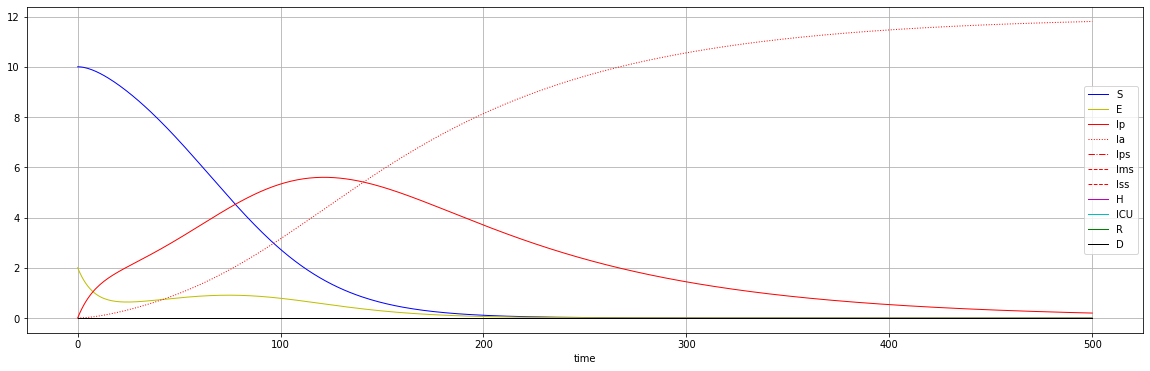

In [65]:
# variable to swtich between plot for c, a and s (0-2)
step = 0

plt.plot(t,res[:,0 + step], 'b-', linewidth=1, label='S')
plt.plot(t,res[:,3 + step], 'y-', linewidth=1, label='E')
plt.plot(t,res[:,6 + step], 'r-', linewidth=1, label='Ip')
plt.plot(t,res[:,9 + step], 'r:', linewidth=1, label='Ia')
plt.plot(t,res[:,12 + step], 'r-.', linewidth=1, label='Ips')
plt.plot(t,res[:,15 + step], 'r--', linewidth=1, label='Ims')
plt.plot(t,res[:,18 + step], 'r--', linewidth=1, label='Iss')
plt.plot(t,res[:,21 + step], 'm-', linewidth=1, label='H')
plt.plot(t,res[:,24 + step], 'c-', linewidth=1, label='ICU')
plt.plot(t,res[:,27 + step], 'g-', linewidth=1, label='R')
plt.plot(t,res[:,30 + step], 'k-', linewidth=1, label='D')

plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

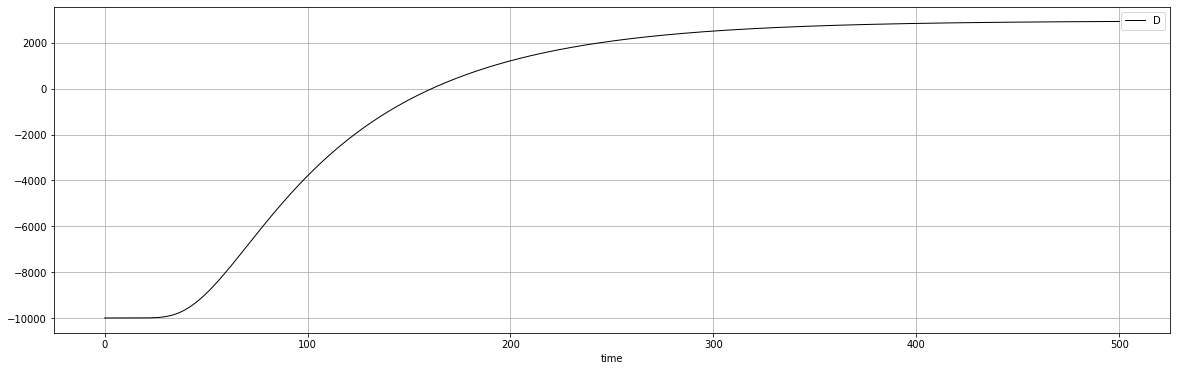

In [85]:
plt.plot(t,res[:,30]-10000, 'k-', linewidth=1, label='D')


plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.rcParams['figure.figsize'] = (20,6)
plt.show()

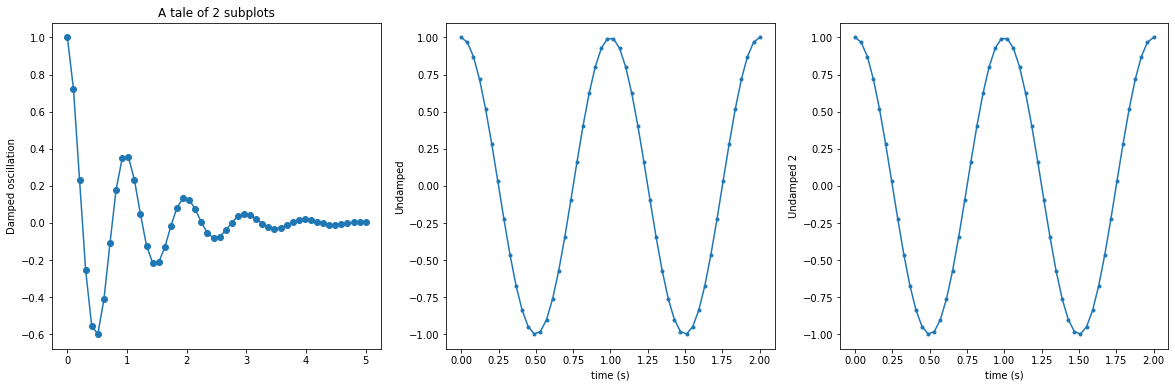

In [105]:

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(1, 3, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(1, 3, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.subplot(1, 3, 3)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped 2')

plt.show()

In [221]:
k_school = [
    [8, 5, 0.7], # c -> c,a,s
    [1.2, 7, 1.5], # a -> c,a,s
    [0.8, 6, 2]] # s -> c,a,s
print(k_school[0][2])

0.7
